# Homework 01 - Intro
Emanuel Tomé\
May 2024

## 1. Load packages

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

## 2. Q1 - Downloading the data

In [2]:
def read_data(filename: str) -> pd.DataFrame:
    "Function to read parquet file"
    return pd.read_parquet(filename)

january_data = read_data('../data/yellow_tripdata_2023-01.parquet')
february_data = read_data('../data/yellow_tripdata_2023-02.parquet')


In [3]:
january_data.shape

(3066766, 19)

In [4]:
january_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## 3. Q2 - Computing duration

In [5]:
def compute_duration(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to compute duration"
    dataframe['duration'] = (
        dataframe['tpep_dropoff_datetime'] - dataframe['tpep_pickup_datetime']
        ).dt.total_seconds()/60
    return dataframe

january_data = compute_duration(january_data)
february_data = compute_duration(february_data)

In [6]:
january_data['duration'].std()

42.59435124195458

In [7]:
january_data['duration'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
1%       7.833333e-01
5%       3.300000e+00
50%      1.151667e+01
95%      3.646667e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

## 4. Q3 - Dropping outliers

In [8]:
def drop_outliers(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to drop outliers"
    return dataframe[(dataframe['duration'] >= 1) & (dataframe['duration'] <= 60)]

In [9]:
january_data_without_outliers = drop_outliers(january_data)
february_data_without_outliers = drop_outliers(february_data)

In [10]:
january_data_without_outliers.shape[0] / january_data.shape[0] * 100


98.1220282212598

In [11]:
february_data_without_outliers.shape[0] / february_data.shape[0] * 100

98.00944077722545

In [12]:
from sklearn.model_selection import train_test_split

# Assuming 'column_name' is the column you want to stratify by
_, january_data_without_outliers = train_test_split(january_data_without_outliers,
                                                    test_size=0.2,
                                                    stratify=january_data_without_outliers['duration'],
                                                    random_state=42)
_, february_data_without_outliers = train_test_split(february_data_without_outliers,
                                                     test_size=0.2,
                                                     stratify=february_data_without_outliers['duration'],
                                                     random_state=42)

## 5. Q4 - One-hot encoding

In [13]:
def cast_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to cast metrics"
    categorical = ['PULocationID', 'DOLocationID']
    dataframe[categorical] = dataframe[categorical].astype('str')
    return dataframe

In [14]:
january_data_without_outliers = cast_metrics(january_data_without_outliers)
february_data_without_outliers = cast_metrics(february_data_without_outliers)

In [15]:
def select_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    "Function to select metrics"
    # Definition of metrics
    categorical = ['PULocationID', 'DOLocationID'] #['PU_DO',]
    numerical = ['trip_distance',]
    
    # Join metrics
    dataframe['PU_DO'] = dataframe['PULocationID'] + '_' + dataframe['DOLocationID']
    
    # Select variables
    filtered_df = dataframe[numerical + categorical].copy()
    
    return filtered_df

In [16]:
train_df = select_metrics(january_data_without_outliers)
test_df = select_metrics(february_data_without_outliers)


In [17]:
# Apply one hot encoding
vec = DictVectorizer()
train_dicts = train_df.to_dict(orient='records')
test_dicts = test_df.to_dict(orient='records')

X_train = vec.fit_transform(train_dicts).toarray()


In [18]:

X_test = vec.transform(test_dicts).toarray()

In [19]:
X_train.shape

(601835, 504)

In [20]:
y_train = january_data_without_outliers['duration']
y_test = february_data_without_outliers['duration']

## 6. Q5 - Training a model

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = lr.predict(X_train)

In [23]:
# Save the model
with open('../models/lin_reg.bin', 'wb') as f:
    pickle.dump((vec, lr), f)

In [24]:
root_mean_squared_error(y_test.values, y_test_pred)

NameError: name 'y_test_pred' is not defined

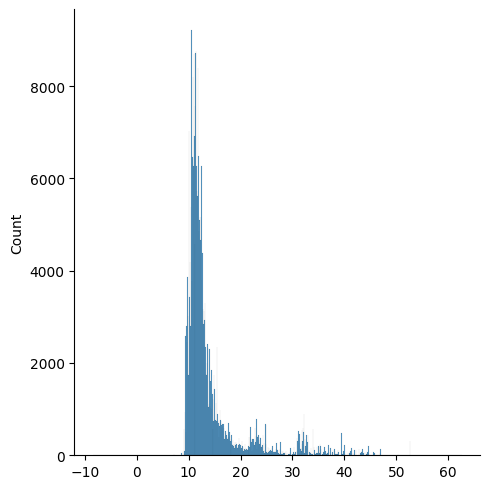

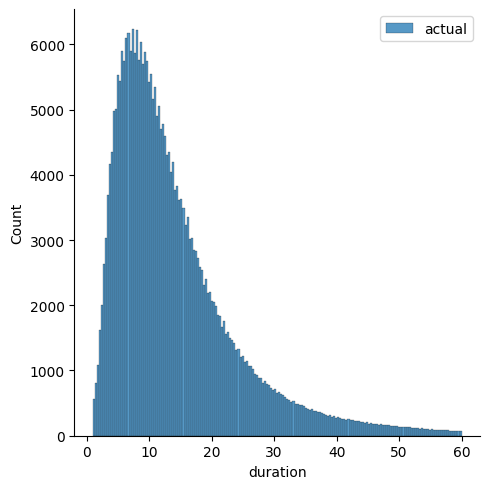

In [ ]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [ ]:
y_pred[y_pred < 1] = 1
y_pred[y_pred > 60] = 60

In [ ]:
root_mean_squared_error(y_train, y_pred)

7.621982704244022

## 7. Q6 - Evaluating the model

In [ ]:
y_test_pred = lr.predict(X_test)

In [ ]:
y_test_pred[y_test_pred < 1] = 1
y_test_pred[y_test_pred > 60] = 60

In [ ]:
root_mean_squared_error(y_test.values, y_test_pred)

7.834410780538673